In [5]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [6]:
import pandas as pd
from pathlib import Path

DATA_FOLDER = Path("../data")

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset.pkl")
collisions_df = collisions.drop(columns=["physicalid", "geometry"])

In [7]:
collisions_df.dropna(subset="traffic_volume", inplace=True)

In [8]:
from sklearn.model_selection import train_test_split

collisions_train, collisions_test = train_test_split(
    collisions_df, test_size=0.2, random_state=42
)

In [14]:
import numpy as np
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy="mean", missing_values=0)
collisions_train[["st_width"]] = mean_imputer.fit_transform(
    collisions_train[["st_width"]]
)

collisions_train["has_bike_lane"] = ~(collisions_train["bike_lane"] == "nan")
collisions_train["has_parking"] = collisions_train["n_parking_meters"] > 0
collisions_train["speed_limit"] = collisions_train["speed_limit"].fillna(value=25)

is_av_mask = (
    (collisions_train["post_type"].isin(["AVE", "BLVD"]))
    | (collisions_train["pre_type"] == "AVE")
    | (collisions_train["st_name"].isin(["BROADWAY", "BOWERY"]))
)
is_st_mask = collisions_train["post_type"] == "ST"
is_rd_mask = collisions_train["post_type"].isin(["RD", "ROAD"])

collisions_train["is_av"] = is_av_mask
collisions_train["is_st"] = is_st_mask
collisions_train["is_rd"] = is_rd_mask

collisions_train["log_leng"] = np.log(collisions_train["shape_leng"])
collisions_train["log_width"] = np.log(collisions_train["st_width"])
collisions_train["inv_trees"] = 1.0 / (1 + collisions_train["n_trees"])
collisions_train["trees_per_leng"] = (
    collisions_train["n_trees"] / collisions_train["shape_leng"]
)
collisions_train["log_traffic_volume"] = np.log1p(collisions_train["traffic_volume"])

In [21]:
linear_reg_features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "inv_trees",
    "log_traffic_volume",
]

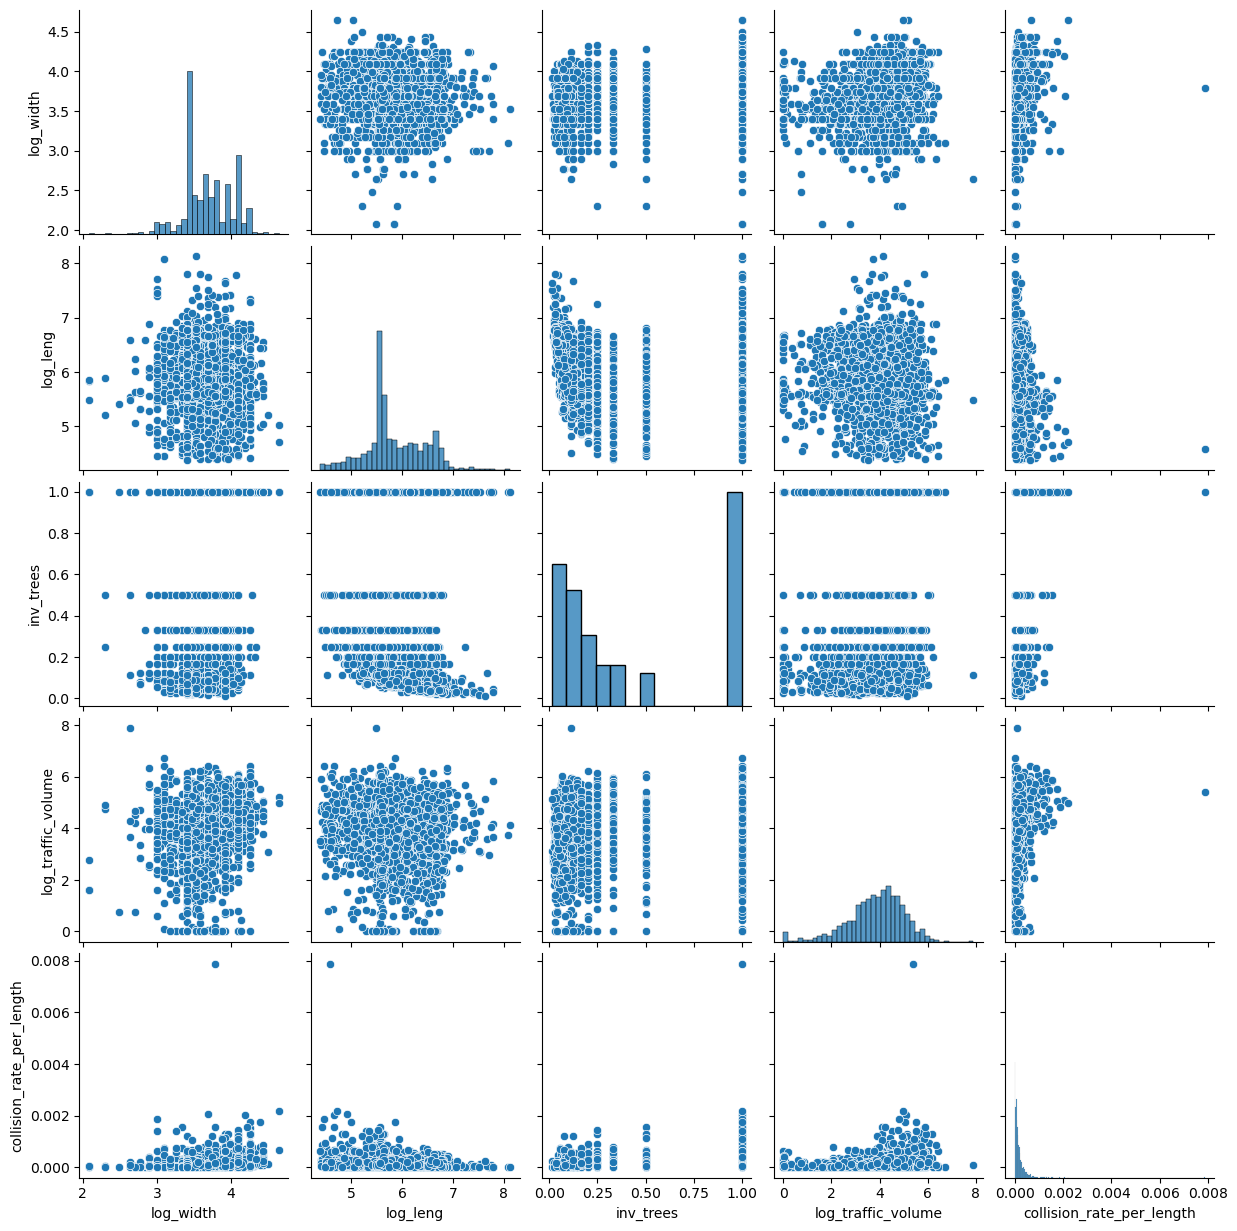

In [25]:
import seaborn as sns

cont_features = ["log_width", "log_leng", "inv_trees", "log_traffic_volume"]
sns.pairplot(collisions_train[cont_features + ["collision_rate_per_length"]])

In [26]:
X_train = collisions_train[linear_reg_features]
y_train = collisions_train["collision_rate_per_length"]

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_norm = scaler.fit_transform(X_train)

In [31]:
y_train.describe()

count    2596.000000
mean        0.000173
std         0.000263
min         0.000000
25%         0.000042
50%         0.000102
75%         0.000216
max         0.007879
Name: collision_rate_per_length, dtype: float64

### Linear regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

base_lin_reg_score = cross_val_score(
    lin_reg, X_norm, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [33]:
import numpy as np

-base_lin_reg_score.mean()

5.655936495242977e-08

In [34]:
lin_reg.fit(X_norm, y_train)

LinearRegression()

In [35]:
import pickle
import os

os.makedirs("../models/regression", exist_ok=True)
with open("../models/regression/base_linear.pkl", "wb") as f:
    pickle.dump(lin_reg, f)

In [40]:
pd.DataFrame(lin_reg.coef_, index=X_train.columns, columns=["coefficient"])

,coefficient
log_width,0.000050
log_leng,-0.000040
has_humps,-0.000007
has_parking,0.000024
has_bike_lane,0.000005
is_av,0.000014
is_st,0.000033
is_rd,-0.000003
inv_trees,0.000030
log_traffic_volume,0.000050


In [89]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso


def get_scores_for_lasso(X_train, y_train, features, min_alpha=0.001, max_alpha=1):
    alphas = np.linspace(min_alpha, max_alpha, 300)

    data_array = np.zeros(shape=(300, len(linear_reg_features) + 3))

    for i, alpha in enumerate(alphas):
        lasso_reg = Lasso(alpha=alpha, max_iter=10000)
        lasso_scores = cross_val_score(
            lasso_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
        )
        val_mse = -lasso_scores.mean()
        lasso_reg.fit(X_train, y_train)
        y_pred = lasso_reg.predict(X_train)
        train_mse = mean_squared_error(y_train, y_pred)
        data_array[i, 0] = alpha
        data_array[i, -2] = train_mse
        data_array[i, -1] = val_mse
        data_array[i, 1:-2] = lasso_reg.coef_
    columns = ["alpha"] + features + ["train_mse", "val_mse"]
    return pd.DataFrame(data_array, columns=columns)

In [90]:
lasso_scores = get_scores_for_lasso(
    X_norm, y_train, linear_reg_features, min_alpha=0.00000000001, max_alpha=0.00001
)

In [91]:
lasso_scores.head(10)

,alpha,log_width,log_leng,has_humps,has_parking,has_bike_lane,is_av,is_st,is_rd,inv_trees,log_traffic_volume,train_mse,val_mse
0,1.000000e-11,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000014,0.000033,-0.000003,0.00003,0.00005,5.630682e-08,5.655936e-08
1,3.345478e-08,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000014,0.000033,-0.000003,0.00003,0.00005,5.630683e-08,5.655943e-08
2,6.689957e-08,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000014,0.000033,-0.000003,0.00003,0.00005,5.630687e-08,5.655953e-08
3,1.003443e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000014,0.000033,-0.000003,0.00003,0.00005,5.630693e-08,5.655964e-08
4,1.337891e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000014,0.000033,-0.000003,0.00003,0.00005,5.630702e-08,5.655979e-08
5,1.672339e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000014,0.000032,-0.000003,0.00003,0.00005,5.630713e-08,5.655996e-08
6,2.006787e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000013,0.000032,-0.000003,0.00003,0.00005,5.630726e-08,5.656014e-08
7,2.341235e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000013,0.000032,-0.000003,0.00003,0.00005,5.630743e-08,5.656036e-08
8,2.675683e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000013,0.000032,-0.000003,0.00003,0.00005,5.630761e-08,5.656061e-08
9,3.010130e-07,0.00005,-0.00004,-0.000007,0.000024,0.000005,0.000013,0.000032,-0.000003,0.00003,0.00005,5.630782e-08,5.656088e-08


Text(0.0, 1.0, 'Train and validation MSE against Lasso alpha')

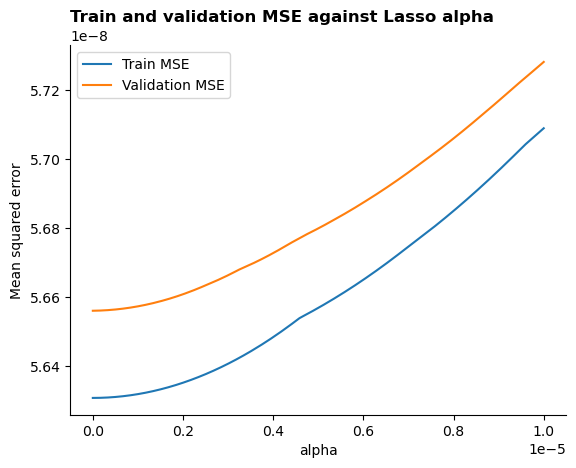

In [92]:
plt.plot(lasso_scores.alpha.values, lasso_scores.train_mse.values, label="Train MSE")
plt.plot(lasso_scores.alpha.values, lasso_scores.val_mse.values, label="Validation MSE")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.legend()
plt.title("Train and validation MSE against Lasso alpha")

**Note**: It seems that the best linear model is the base one. And we also have the MSE score to beat: $5.65\times 10^{-8}$.

### Random forests

In [111]:
forest_features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "trees_per_leng",
    "log_traffic_volume",
]

In [136]:
from sklearn.ensemble import RandomForestRegressor

base_rnd_forest = RandomForestRegressor(n_estimators=500, min_samples_split=20)

In [137]:
X_train = collisions_train[forest_features]

In [138]:
rnd_forests_scores = cross_val_score(
    base_rnd_forest, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [139]:
-rnd_forests_scores.mean()

5.6576072818561655e-08

In [143]:
from sklearn.model_selection import GridSearchCV

grid = {
    "n_estimators": [50, 75, 100, 300, 500, 1000],
    "min_samples_split": [10, 20, 50, 100],
    "max_depth": [2, 5, 10],
}

grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    return_train_score=True,
)

In [144]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'min_samples_split': [10, 20, 50, 100],
                         'n_estimators': [50, 75, 100, 300, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [146]:
grid_search.best_score_

-5.646704367556355e-08

In [148]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=1000)

In [152]:
grid_search.best_estimator_.feature_importances_, grid_search.best_estimator_.feature_names_in_

(array([0.25315836, 0.31637102, 0.00066944, 0.02483783, 0.01003207,
        0.00435383, 0.03030977, 0.00214636, 0.04657408, 0.31154724]),
 array(['log_width', 'log_leng', 'has_humps', 'has_parking',
        'has_bike_lane', 'is_av', 'is_st', 'is_rd', 'trees_per_leng',
        'log_traffic_volume'], dtype=object))

In [153]:
grid = {"n_estimators": [1000, 2000, 4000], "max_depth": [10, 20, 50]}


grid_search_2 = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    return_train_score=True,
)

grid_search_2.fit(X_train, y_train)

/home/pjlemos/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50],
                         'n_estimators': [1000, 2000, 4000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [155]:
grid_search_2.best_score_

-5.934892314692911e-08

### XGBoost

In [156]:
import xgboost